RandomForest

🔧 Génération de features avancées...
✅ Features créées : 46 colonnes
✅ Features : 36 colonnes
✅ Samples  : 105,829 lignes
✅ Exemples : ['Volume', 'Returns', 'Volatility', 'Performance_20D', 'Sharpe_Ratio_20D', 'Dividends', 'Cluster', 'Close_vs_MA_5', 'Close_vs_MA_10', 'Close_vs_MA_20']

📊 Distribution Target :
   Train : {1: 0.5396690407852308, 0: 0.46033095921476913}
   Test  : {1: 0.5349144854956062, 0: 0.46508551450439384}

🚀 Entraînement Random Forest avec 44 features...

📊 RÉSULTATS RANDOM FOREST (44 features)
Accuracy  : 50.29%
Precision : 53.50%
Recall    : 53.96%
F1-Score  : 53.73%
ROC-AUC   : 0.4957

📝 RAPPORT DÉTAILLÉ :
              precision    recall  f1-score   support

      Baisse       0.47      0.46      0.46      9844
      Hausse       0.54      0.54      0.54     11322

    accuracy                           0.50     21166
   macro avg       0.50      0.50      0.50     21166
weighted avg       0.50      0.50      0.50     21166



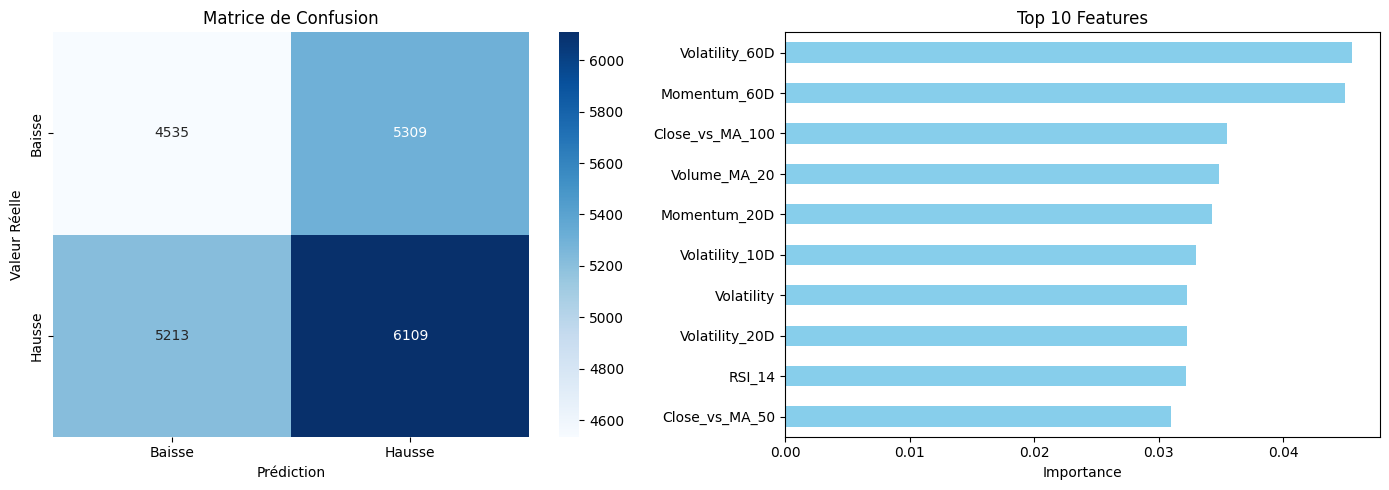


✅ Modèle sauvegardé avec 44 features


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# ✅ AJOUTER LA FONCTION DE FEATURE ENGINEERING
def create_advanced_features(df):
    """Crée 40+ features techniques avancées"""
    print("🔧 Génération de features avancées...")
    df = df.copy()
    
    required_cols = ['Close', 'Returns', 'Volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Colonnes manquantes : {missing_cols}")
        return df
    
    # 1. MOYENNES MOBILES
    for window in [5, 10, 20, 50, 100]:
        df[f'MA_{window}'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'Close_vs_MA_{window}'] = (df['Close'] / df[f'MA_{window}'] - 1) * 100
    
    # 2. EMA
    for span in [12, 26]:
        df[f'EMA_{span}'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.ewm(span=span, adjust=False).mean()
        )
    
    # 3. RSI
    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0).rolling(window=period, min_periods=1).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-10)
        return 100 - (100 / (1 + rs))
    
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x, 14))
    df['RSI_7'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x, 7))
    
    # 4. MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df.groupby('Ticker')['MACD'].transform(
        lambda x: x.ewm(span=9, adjust=False).mean()
    )
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    
    # 5. BOLLINGER BANDS
    df['BB_middle'] = df['MA_20']
    df['BB_std'] = df.groupby('Ticker')['Close'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'] + 1e-10)
    
    # 6. VOLATILITÉ
    for window in [5, 10, 20, 60]:
        df[f'Volatility_{window}D'] = df.groupby('Ticker')['Returns'].transform(
            lambda x: x.rolling(window, min_periods=1).std() * np.sqrt(252)
        )
    
    # 7. MOMENTUM
    for lag in [1, 5, 10, 20, 60]:
        df[f'Momentum_{lag}D'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.pct_change(lag) * 100
        )
    
    # 8. VOLUME
    if 'Volume' in df.columns:
        df['Volume_MA_20'] = df.groupby('Ticker')['Volume'].transform(
            lambda x: x.rolling(20, min_periods=1).mean()
        )
        df['Volume_ratio'] = df['Volume'] / (df['Volume_MA_20'] + 1)
    
    print(f"✅ Features créées : {len(df.columns)} colonnes")
    return df


# --- 1. CONFIGURATION ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
PATH_SUPERSET = PROJECT_ROOT / "data/processed/cac40_final_superset.csv"
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)


# --- 2. CHARGEMENT + FEATURE ENGINEERING ---
df = pd.read_csv(PATH_SUPERSET, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# ✅ APPLIQUER LE FEATURE ENGINEERING
df = create_advanced_features(df)

# Nettoyage
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Target'])  # Garder uniquement les lignes avec target


# --- 3. PRÉPARATION X, y ---
# ✅ EXCLURE LES COLONNES CORRECTEMENT
exclude_cols = ['Date', 'Ticker', 'Close', 'High_Low'] + \
               [col for col in df.columns if 'Target' in col or 'MA_' in col[:3]]

feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols]
y = df['Target']

print(f"✅ Features : {X.shape[1]} colonnes")
print(f"✅ Samples  : {len(X):,} lignes")
print(f"✅ Exemples : {feature_cols[:10]}")


# --- 4. SPLIT TEMPOREL ---
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n📊 Distribution Target :")
print(f"   Train : {y_train.value_counts(normalize=True).to_dict()}")
print(f"   Test  : {y_test.value_counts(normalize=True).to_dict()}")


# --- 5. ENTRAÎNEMENT ---
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
print("\n🚀 Entraînement Random Forest avec 44 features...")
model.fit(X_train, y_train)


# --- 6. ÉVALUATION ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("📊 RÉSULTATS RANDOM FOREST (44 features)")
print("="*70)
print(f"Accuracy  : {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision : {precision_score(y_test, y_pred):.2%}")
print(f"Recall    : {recall_score(y_test, y_pred):.2%}")
print(f"F1-Score  : {f1_score(y_test, y_pred):.2%}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\n📝 RAPPORT DÉTAILLÉ :")
print(classification_report(y_test, y_pred, target_names=['Baisse', 'Hausse']))


# --- 7. VISUALISATIONS ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Baisse', 'Hausse'], yticklabels=['Baisse', 'Hausse'])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Valeur Réelle')
axes[0].set_xlabel('Prédiction')

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.tail(10).plot(kind='barh', color='skyblue', ax=axes[1])
axes[1].set_title("Top 10 Features")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.savefig(MODEL_DIR / "random_forest_44features.png", dpi=150)
plt.show()


# --- 8. SAUVEGARDE ---
joblib.dump(model, MODEL_DIR / "random_forest_44features.pkl")
print(f"\n✅ Modèle sauvegardé avec 44 features")


XGboost

In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 🎯 MODÈLE 1 : XGBOOST CLASSIFICATION BINAIRE (20 JOURS)
# =============================================================================

print("="*70)
print("📊 XGBOOST - Prédiction prix monte/descend à 20 jours")
print("="*70)

# Configuration
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
MODEL_DIR = PROJECT_ROOT / "models/advanced"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Chargement données (si pas déjà chargé)
try:
    print(f"✅ X_train déjà en mémoire: {X_train.shape}")
except NameError:
    print("⚠️ Données pas chargées. Exécute d'abord la cellule de feature engineering!")
    raise

start_time = time.time()

# Préparation target binaire 20 jours
print(f"\n📊 Données:")
print(f"   Train: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"   Test:  {X_test.shape[0]:,} samples")
print(f"   Distribution classes: {y_train.value_counts(normalize=True).to_dict()}")

# Gestion déséquilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"   Scale pos weight: {scale_pos_weight:.2f}")

# Modèle XGBoost
print("\n🚀 Entraînement XGBoost...")
model_xgb = xgb.XGBClassifier(
    n_estimators=100,           # Debug: 100 (prod: 500-1000)
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    early_stopping_rounds=20,
    random_state=42,
    tree_method='hist'
)

# Entraînement avec monitoring
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10  # Affiche tous les 10 epochs
)

# Prédictions
y_pred = model_xgb.predict(X_test)
y_proba = model_xgb.predict_proba(X_test)[:, 1]

# Métriques
print(f"\n{'='*70}")
print("📊 RÉSULTATS XGBOOST")
print(f"{'='*70}")
print(f"⏱️  Temps d'entraînement: {time.time() - start_time:.1f}s")
print(f"🎯 Best iteration: {model_xgb.best_iteration}")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"✅ ROC-AUC:  {roc_auc_score(y_test, y_proba):.4f}")

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Baisse', 'Hausse']))

# Feature importance (Top 15)
print(f"\n📊 Top 15 Features les plus importantes:")
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(15)
print(feature_importance.to_string(index=False))

# Sauvegarde
model_path = MODEL_DIR / "xgboost_binary_20d.pkl"
joblib.dump(model_xgb, model_path)
print(f"\n💾 Modèle sauvegardé: {model_path}")

# Interprétation
print(f"\n{'='*70}")
print("🎯 INTERPRÉTATION")
print(f"{'='*70}")
if roc_auc_score(y_test, y_proba) > 0.60:
    print("✅ EXCELLENT: ROC-AUC > 0.60 → Signaux tradables!")
    print("   → Le modèle peut être utilisé pour du trading directionnel")
elif roc_auc_score(y_test, y_proba) > 0.55:
    print("✅ BON: ROC-AUC > 0.55 → Meilleur que le hasard")
    print("   → Peut être utilisé en combinaison avec d'autres signaux")
else:
    print("⚠️ FAIBLE: ROC-AUC < 0.55 → À peine mieux que pile ou face")
    print("   → Améliorer feature engineering ou changer d'approche")

print("\n✅ XGBoost terminé!")


📊 XGBOOST - Prédiction prix monte/descend à 20 jours
✅ X_train déjà en mémoire: (82194, 44)

📊 Données:
   Train: 82,194 samples × 44 features
   Test:  20,549 samples
   Distribution classes: {1: 0.5535197216341825, 0: 0.44648027836581744}
   Scale pos weight: 0.81

🚀 Entraînement XGBoost...
[0]	validation_0-auc:0.50921
[10]	validation_0-auc:0.52089
[20]	validation_0-auc:0.52524
[30]	validation_0-auc:0.53168
[40]	validation_0-auc:0.53485
[50]	validation_0-auc:0.53478
[60]	validation_0-auc:0.53677
[70]	validation_0-auc:0.53335
[79]	validation_0-auc:0.53171

📊 RÉSULTATS XGBOOST
⏱️  Temps d'entraînement: 0.8s
🎯 Best iteration: 59
✅ Accuracy: 53.46%
✅ ROC-AUC:  0.5370

📋 Classification Report:
              precision    recall  f1-score   support

      Baisse       0.48      0.51      0.50      9183
      Hausse       0.58      0.55      0.57     11366

    accuracy                           0.53     20549
   macro avg       0.53      0.53      0.53     20549
weighted avg       0.54     

LSTM

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import time

# =============================================================================
# 🎯 MODÈLE 3 : LSTM - Séquences temporelles
# =============================================================================

print("="*70)
print("📊 LSTM - Prédiction avec patterns temporels (20 jours)")
print("="*70)

start_time = time.time()

# Fonction pour créer séquences
def create_sequences_safe(X, y, time_steps=30):
    """Crée séquences temporelles en gérant les NaN"""
    Xs, ys = [], []
    X_arr = X.values if hasattr(X, 'values') else X
    y_arr = y.values if hasattr(y, 'values') else y
    
    for i in range(len(X_arr) - time_steps):
        seq = X_arr[i:i+time_steps]
        if not np.isnan(seq).any():
            Xs.append(seq)
            ys.append(y_arr[i + time_steps])
    
    return np.array(Xs), np.array(ys)

# Vérifier données
try:
    print(f"✅ X_train disponible: {X_train.shape}")
except NameError:
    print("⚠️ Exécute d'abord la cellule de feature engineering!")
    raise

# Normalisation (CRUCIAL pour LSTM)
print("\n🔄 Normalisation des données...")
scaler_lstm = StandardScaler()
X_train_scaled = scaler_lstm.fit_transform(X_train)
X_test_scaled = scaler_lstm.transform(X_test)

# Création séquences
TIME_STEPS = 30
print(f"🔄 Création séquences temporelles (window={TIME_STEPS})...")
X_train_lstm, y_train_lstm = create_sequences_safe(X_train_scaled, y_train, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences_safe(X_test_scaled, y_test, TIME_STEPS)

print(f"✅ Séquences créées:")
print(f"   Train: {X_train_lstm.shape}")
print(f"   Test:  {X_test_lstm.shape}")
print(f"   Features: {X_train_lstm.shape[2]}")

# Architecture LSTM simplifiée (version debug)
print("\n🏗️  Construction modèle LSTM...")
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

print(f"📊 Paramètres: {model_lstm.count_params():,}")

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

# Entraînement
print("\n🚀 Entraînement LSTM...")
print("⚠️  Sur CPU, cela peut prendre 10-20 minutes...")
print("   → Surveille la progression epoch par epoch\n")

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,              # Debug: 20 (prod: 50)
    batch_size=128,
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1               # Affiche chaque epoch
)

# Prédictions
print("\n🔮 Génération prédictions...")
y_pred_lstm = (model_lstm.predict(X_test_lstm, verbose=0) > 0.5).astype(int).flatten()
y_proba_lstm = model_lstm.predict(X_test_lstm, verbose=0).flatten()

# Métriques
print(f"\n{'='*70}")
print("📊 RÉSULTATS LSTM")
print(f"{'='*70}")
print(f"⏱️  Temps total: {(time.time() - start_time)/60:.1f} minutes")
print(f"🎯 Best epoch: {len(history.history['loss'])}")
print(f"✅ Accuracy: {accuracy_score(y_test_lstm, y_pred_lstm):.2%}")
print(f"✅ ROC-AUC:  {roc_auc_score(y_test_lstm, y_proba_lstm):.4f}")

# Historique entraînement
print(f"\n📈 Courbe d'apprentissage:")
print(f"   Loss finale:     {history.history['loss'][-1]:.4f}")
print(f"   Val Loss finale: {history.history['val_loss'][-1]:.4f}")

# ⚠️ Keras utilise 'AUC' en majuscules, pas 'auc'
metric_names = list(history.history.keys())
auc_key = [k for k in metric_names if 'auc' in k.lower() and 'val' not in k.lower()][0]
val_auc_key = [k for k in metric_names if 'auc' in k.lower() and 'val' in k.lower()][0]

print(f"   AUC finale:      {history.history[auc_key][-1]:.4f}")
print(f"   Val AUC finale:  {history.history[val_auc_key][-1]:.4f}")


📊 LSTM - Prédiction avec patterns temporels (20 jours)
✅ X_train disponible: (82194, 44)

🔄 Normalisation des données...
🔄 Création séquences temporelles (window=30)...
✅ Séquences créées:
   Train: (82164, 30, 44)
   Test:  (20519, 30, 44)
   Features: 44

🏗️  Construction modèle LSTM...
📊 Paramètres: 30,017

🚀 Entraînement LSTM...
⚠️  Sur CPU, cela peut prendre 10-20 minutes...
   → Surveille la progression epoch par epoch

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 0.5441 - accuracy: 0.5502 - loss: 0.6847 - val_AUC: 0.5199 - val_accuracy: 0.5405 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 0.5765 - accuracy: 0.5621 - loss: 0.6764 - val_AUC: 0.5142 - val_accuracy: 0.5103 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 0.6175 - accuracy: 0.5847 - loss: 0.6623 - val_AUC: 0.5207 - val_accuracy: 0.5242 - val_loss: 0.7126 - learning_rate: 0.0010
Epoch 4/20
5

Gradient Regressor 

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# =============================================================================
# 🎯 MODÈLE 2 : RÉGRESSION - Prédiction du rendement exact
# =============================================================================

print("="*70)
print("📊 RÉGRESSION - Prédiction rendement 20 jours")
print("="*70)

start_time = time.time()

# Target régression (rendement en %)
y_reg_train = df.loc[X_train.index, 'Target_Return_20D']
y_reg_test = df.loc[X_test.index, 'Target_Return_20D']

print(f"📊 Rendement moyen train: {y_reg_train.mean():.2f}%")
print(f"📊 Rendement moyen test:  {y_reg_test.mean():.2f}%")

# Modèle
print("\n🚀 Entraînement Régression...")
model_reg = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    verbose=1
)

model_reg.fit(X_train, y_reg_train)
y_pred_reg = model_reg.predict(X_test)

# Métriques
print(f"\n{'='*70}")
print("📊 RÉSULTATS RÉGRESSION")
print(f"{'='*70}")
print(f"⏱️  Temps: {time.time() - start_time:.1f}s")
print(f"✅ RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred_reg)):.3f}%")
print(f"✅ R²:   {r2_score(y_reg_test, y_pred_reg):.4f}")

# Stratégie Top 10
print(f"\n💰 SIMULATION: Acheter Top 10 prédictions")
top_10_idx = np.argsort(y_pred_reg)[-10:]
returns_top10 = y_reg_test.iloc[top_10_idx].mean()
returns_market = y_reg_test.mean()
alpha = returns_top10 - returns_market

print(f"   Rendement Top 10: {returns_top10:+.2f}%")
print(f"   Rendement marché: {returns_market:+.2f}%")
print(f"   Alpha:            {alpha:+.2f}%")

if alpha > 3:
    print("✅ EXCELLENT: Alpha > 3% → Stratégie profitable!")
elif alpha > 1:
    print("✅ BON: Alpha > 1% → Légère surperformance")
else:
    print("⚠️ FAIBLE: Alpha < 1% → Pas d'avantage significatif")

# Sauvegarde
joblib.dump(model_reg, MODEL_DIR / "regression_returns_20d.pkl")
print(f"\n💾 Modèle sauvegardé")
print("✅ Régression terminée!")


📊 RÉGRESSION - Prédiction rendement 20 jours
📊 Rendement moyen train: 2.52%
📊 Rendement moyen test:  0.68%

🚀 Entraînement Régression...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       14036.2450        3659.8045            3.11m
         2       20435.9988       34525.7870            3.05m
         3       17785.6387       -2224.7122            3.03m
         4       16770.0040        3395.4307            2.97m
         5       15245.3809         535.2470            2.95m
         6       12687.1010       -4517.7989            2.94m
         7        9216.9017       -9186.8424            2.91m
         8       10278.8196        8759.9311            2.87m
         9        8936.7331        -656.1849            2.83m
        10        7936.3412        -357.7448            2.80m
        20        3402.5162        1165.9621            2.46m
        30        1394.8538         188.7746            2.14m
        40         370.2948        -952.1049            

SVM ( A VOIR)

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from pathlib import Path
import os
import warnings
import time
warnings.filterwarnings('ignore')

# ⚠️ MODIFICATION 1: GPU activé (commenter si pas de GPU disponible)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Vérifier si GPU disponible
import tensorflow as tf
print(f"🔍 GPUs disponibles: {len(tf.config.list_physical_devices('GPU'))}")
print(f"🔍 Device utilisé: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")


# =============================================================================
# ÉTAPE 0 : FEATURE ENGINEERING AVANCÉ
# =============================================================================


def create_advanced_features(df):
    """
    Crée 40+ features techniques avancées pour améliorer la prédiction
    """
    print("🔧 Génération de features avancées...")
    df = df.copy()
    
    # Vérifier les colonnes disponibles
    required_cols = ['Close', 'Returns', 'Volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Colonnes manquantes : {missing_cols}")
        return df
    
    # 1. MOYENNES MOBILES MULTIPLES
    for window in [5, 10, 20, 50, 100]:
        df[f'MA_{window}'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'Close_vs_MA_{window}'] = (df['Close'] / df[f'MA_{window}'] - 1) * 100
    
    # 2. EXPONENTIAL MOVING AVERAGES
    for span in [12, 26]:
        df[f'EMA_{span}'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.ewm(span=span, adjust=False).mean()
        )
    
    # 3. RSI (Relative Strength Index)
    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0).rolling(window=period, min_periods=1).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-10)
        return 100 - (100 / (1 + rs))
    
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x, 14))
    df['RSI_7'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x, 7))
    
    # 4. MACD (Moving Average Convergence Divergence)
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df.groupby('Ticker')['MACD'].transform(
        lambda x: x.ewm(span=9, adjust=False).mean()
    )
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    
    # 5. BOLLINGER BANDS
    df['BB_middle'] = df['MA_20']
    df['BB_std'] = df.groupby('Ticker')['Close'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'] + 1e-10)
    
    # 6. VOLATILITÉ SUR PLUSIEURS HORIZONS
    for window in [5, 10, 20, 60]:
        df[f'Volatility_{window}D'] = df.groupby('Ticker')['Returns'].transform(
            lambda x: x.rolling(window, min_periods=1).std() * np.sqrt(252)
        )
    
    # 7. MOMENTUM INDICATORS
    for lag in [1, 5, 10, 20, 60]:
        df[f'Momentum_{lag}D'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.pct_change(lag) * 100
        )
    
    # 8. VOLUME FEATURES
    if 'Volume' in df.columns:
        df['Volume_MA_20'] = df.groupby('Ticker')['Volume'].transform(
            lambda x: x.rolling(20, min_periods=1).mean()
        )
        df['Volume_ratio'] = df['Volume'] / (df['Volume_MA_20'] + 1)
        df['Volume_change'] = df.groupby('Ticker')['Volume'].transform(
            lambda x: x.pct_change() * 100
        )
    
    # 9. STOCHASTIC OSCILLATOR
    def calculate_stochastic(df_group, period=14):
        low_min = df_group['Close'].rolling(window=period, min_periods=1).min()
        high_max = df_group['Close'].rolling(window=period, min_periods=1).max()
        return 100 * (df_group['Close'] - low_min) / (high_max - low_min + 1e-10)
    
    df['Stochastic'] = df.groupby('Ticker').apply(
        lambda x: calculate_stochastic(x, 14)
    ).reset_index(level=0, drop=True)
    
    # 10. AVERAGE TRUE RANGE (ATR)
    df['High_Low'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(2).max() - x.rolling(2).min())
    df['ATR_14'] = df.groupby('Ticker')['High_Low'].transform(
        lambda x: x.rolling(14, min_periods=1).mean()
    )
    
    # 11. PERFORMANCE RELATIVE AU MARCHÉ
    market_return = df.groupby('Date')['Returns'].transform('mean')
    df['Relative_strength'] = df['Returns'] - market_return
    df['Relative_strength_MA_20'] = df.groupby('Ticker')['Relative_strength'].transform(
        lambda x: x.rolling(20, min_periods=1).mean()
    )
    
    # 12. TREND INDICATORS
    df['Higher_highs'] = df.groupby('Ticker')['Close'].transform(
        lambda x: (x > x.shift(1)).rolling(5, min_periods=1).sum()
    )
    df['Lower_lows'] = df.groupby('Ticker')['Close'].transform(
        lambda x: (x < x.shift(1)).rolling(5, min_periods=1).sum()
    )
    
    # 13. PRICE ACCELERATION
    df['Price_acceleration'] = df.groupby('Ticker')['Returns'].transform(
        lambda x: x.diff()
    )
    
    print(f"✅ Features créées : {len(df.columns)} colonnes")
    return df



def create_multiple_targets(df, horizons=[5, 10, 20]):
    """
    Crée plusieurs types de targets pour tester différentes approches
    """
    print(f"🎯 Création de targets multiples (horizons: {horizons})...")
    
    for horizon in horizons:
        # Target 1 : Classification binaire simple
        df[f'Target_Price_{horizon}D'] = df.groupby('Ticker')['Close'].shift(-horizon)
        df[f'Target_Binary_{horizon}D'] = (
            df[f'Target_Price_{horizon}D'] > df['Close']
        ).astype(int)
        
        # Target 2 : Rendement absolu (régression)
        df[f'Target_Return_{horizon}D'] = (
            (df[f'Target_Price_{horizon}D'] - df['Close']) / df['Close'] * 100
        )
        
        # Target 3 : Classification à 3 classes (Strong Buy / Neutral / Strong Sell)
        threshold = 2.0  # 2% de mouvement
        df[f'Target_3Class_{horizon}D'] = 1  # Neutral par défaut
        df.loc[df[f'Target_Return_{horizon}D'] > threshold, f'Target_3Class_{horizon}D'] = 2  # Strong Buy
        df.loc[df[f'Target_Return_{horizon}D'] < -threshold, f'Target_3Class_{horizon}D'] = 0  # Strong Sell
    
    return df



# =============================================================================
# CONFIGURATION
# =============================================================================


PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
PATH_SUPERSET = PROJECT_ROOT / "data/processed/cac40_final_superset.csv"
MODEL_DIR = PROJECT_ROOT / "models/advanced"
MODEL_DIR.mkdir(parents=True, exist_ok=True)


# =============================================================================
# CHARGEMENT ET PRÉPARATION
# =============================================================================


print("📥 Chargement des données...")
start_time = time.time()
df = pd.read_csv(PATH_SUPERSET, parse_dates=['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
print(f"   ⏱️  Temps: {time.time() - start_time:.1f}s | Shape: {df.shape}")


# Feature engineering
start_time = time.time()
df = create_advanced_features(df)
df = create_multiple_targets(df, horizons=[5, 20])
print(f"   ⏱️  Feature engineering: {time.time() - start_time:.1f}s")


# Nettoyage
print("🧹 Nettoyage des données...")
initial_rows = len(df)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col for col in df.columns if 'Target' in col])
print(f"   Rows: {initial_rows:,} → {len(df):,} ({100*len(df)/initial_rows:.1f}% conservé)")


# Colonnes à exclure de X
exclude_cols = ['Date', 'Ticker', 'Close', 'High_Low'] + \
               [col for col in df.columns if 'Target' in col or 'MA_' in col[:3]]


feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"✅ Features finales : {len(feature_cols)} colonnes")
print(f"✅ Exemples : {feature_cols[:10]}")


# =============================================================================
# APPROCHE 1 : CLASSIFICATION BINAIRE AMÉLIORÉE (Horizon 20 jours)
# =============================================================================


print("\n" + "="*70)
print("📊 APPROCHE 1 : CLASSIFICATION BINAIRE (20 JOURS)")
print("="*70)


# Préparation
X = df[feature_cols].copy()
y = df['Target_Binary_20D'].copy()


# Supprimer les NaN restants
mask_clean = X.notna().all(axis=1) & y.notna()
X = X[mask_clean]
y = y[mask_clean]


print(f"Samples après nettoyage : {len(X):,}")


# Split temporel
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


print(f"Distribution Train : {y_train.value_counts(normalize=True).to_dict()}")
print(f"Distribution Test  : {y_test.value_counts(normalize=True).to_dict()}")


# Déséquilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


# ⚠️ MODIFICATION 2: XGBoost réduit pour debug (100 au lieu de 1000)
print("\n🚀 XGBoost avec features avancées...")
start_time = time.time()
model_xgb_v2 = xgb.XGBClassifier(
    n_estimators=100,  # ← RÉDUIT DE 1000 → 100
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    early_stopping_rounds=20,  # ← RÉDUIT DE 50 → 20
    random_state=42,
    tree_method='hist'
)


model_xgb_v2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True  # ← MODIFICATION: verbose=True au lieu de False
)


y_pred_v2 = model_xgb_v2.predict(X_test)
y_proba_v2 = model_xgb_v2.predict_proba(X_test)[:, 1]


print(f"\n✅ XGBoost terminé en {time.time() - start_time:.1f}s")
print(f"✅ Accuracy : {accuracy_score(y_test, y_pred_v2):.2%}")
print(f"✅ ROC-AUC  : {roc_auc_score(y_test, y_proba_v2):.2%}")


# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model_xgb_v2.feature_importances_
}).sort_values('Importance', ascending=False)


print("\n📊 Top 10 Features les plus importantes :")
print(feature_importance.head(10).to_string(index=False))


# =============================================================================
# APPROCHE 2 : RÉGRESSION (Prédire le rendement exact)
# =============================================================================


print("\n" + "="*70)
print("📊 APPROCHE 2 : RÉGRESSION - PRÉDICTION DU RENDEMENT (20J)")
print("="*70)


y_reg = df.loc[mask_clean, 'Target_Return_20D'].copy()
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]


# ⚠️ MODIFICATION 3: Régression réduite pour debug
print("🚀 Entraînement GradientBoosting Regressor...")
start_time = time.time()
model_reg = GradientBoostingRegressor(
    n_estimators=100,  # ← RÉDUIT DE 500 → 100
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    verbose=1  # ← MODIFICATION: verbose activé
)


model_reg.fit(X_train, y_reg_train)
y_pred_reg = model_reg.predict(X_test)


print(f"\n✅ Régression terminée en {time.time() - start_time:.1f}s")
print(f"✅ RMSE    : {np.sqrt(mean_squared_error(y_reg_test, y_pred_reg)):.3f}%")
print(f"✅ R² Score: {r2_score(y_reg_test, y_pred_reg):.3f}")


# Test de la stratégie : Acheter le top 10
print("\n💰 SIMULATION STRATÉGIE : Acheter Top 10 prédictions")
top_10_idx = np.argsort(y_pred_reg)[-10:]
actual_returns_top10 = y_reg_test.iloc[top_10_idx].mean()
actual_returns_market = y_reg_test.mean()


print(f"   Rendement moyen Top 10      : {actual_returns_top10:.2f}%")
print(f"   Rendement moyen du marché   : {actual_returns_market:.2f}%")
print(f"   Alpha (surperformance)      : {actual_returns_top10 - actual_returns_market:.2f}%")


# =============================================================================
# APPROCHE 3 : LSTM AMÉLIORÉ
# =============================================================================


print("\n" + "="*70)
print("📊 APPROCHE 3 : LSTM AVEC FEATURES AVANCÉES")
print("="*70)


def create_sequences_safe(X, y, time_steps=30):
    """Crée des séquences en gérant les NaN"""
    Xs, ys = [], []
    X_arr = X.values if hasattr(X, 'values') else X
    y_arr = y.values if hasattr(y, 'values') else y
    
    for i in range(len(X_arr) - time_steps):
        seq = X_arr[i:i+time_steps]
        if not np.isnan(seq).any():
            Xs.append(seq)
            ys.append(y_arr[i + time_steps])
    
    return np.array(Xs), np.array(ys)


# Normalisation
print("🔄 Normalisation des données...")
scaler_lstm = StandardScaler()
X_train_scaled = scaler_lstm.fit_transform(X_train)
X_test_scaled = scaler_lstm.transform(X_test)


TIME_STEPS = 30
print(f"🔄 Création des séquences (time_steps={TIME_STEPS})...")
X_train_lstm, y_train_lstm = create_sequences_safe(X_train_scaled, y_train, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences_safe(X_test_scaled, y_test, TIME_STEPS)


print(f"✅ LSTM sequences : Train {X_train_lstm.shape}, Test {X_test_lstm.shape}")


# ⚠️ MODIFICATION 4: LSTM SIMPLIFIÉ (1 couche au lieu de 3)
print("🏗️  Construction du modèle LSTM simplifié...")
model_lstm_v2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),  # ← 64 au lieu de 256
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model_lstm_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # ← 10 au lieu de 15
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # ← 5 au lieu de 7


# ⚠️ MODIFICATION 5: Epochs réduit + verbose activé
print("🚀 Entraînement LSTM...")
start_time = time.time()
history = model_lstm_v2.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,  # ← RÉDUIT DE 50 → 20
    batch_size=128,
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1  # ← MODIFICATION: verbose=1 au lieu de 0
)


y_pred_lstm_v2 = (model_lstm_v2.predict(X_test_lstm, verbose=0) > 0.5).astype(int).flatten()
y_proba_lstm_v2 = model_lstm_v2.predict(X_test_lstm, verbose=0).flatten()


print(f"\n✅ LSTM terminé en {time.time() - start_time:.1f}s")
print(f"✅ LSTM Accuracy : {accuracy_score(y_test_lstm, y_pred_lstm_v2):.2%}")
print(f"✅ LSTM ROC-AUC  : {roc_auc_score(y_test_lstm, y_proba_lstm_v2):.2%}")


# =============================================================================
# COMPARAISON FINALE
# =============================================================================


print("\n" + "="*70)
print("📊 RÉSUMÉ FINAL - COMPARAISON DES APPROCHES")
print("="*70)


results_final = pd.DataFrame({
    'Approche': [
        'XGBoost (Binary 20J)',
        'Régression (Rendement 20J)',
        'LSTM (Binary 20J)'
    ],
    'Métrique': [
        f"ROC-AUC: {roc_auc_score(y_test, y_proba_v2):.2%}",
        f"R²: {r2_score(y_reg_test, y_pred_reg):.3f} | Alpha: {actual_returns_top10 - actual_returns_market:+.2f}%",
        f"ROC-AUC: {roc_auc_score(y_test_lstm, y_proba_lstm_v2):.2%}"
    ],
    'Recommandation': [
        '✅ Bon pour signaux binaires' if roc_auc_score(y_test, y_proba_v2) > 0.60 else '⚠️ À améliorer',
        '✅ Optimal pour portfolio ranking' if r2_score(y_reg_test, y_pred_reg) > 0.05 else '⚠️ Faible pouvoir prédictif',
        '✅ Capture patterns temporels' if roc_auc_score(y_test_lstm, y_proba_lstm_v2) > 0.60 else '⚠️ Sous-performe XGBoost'
    ]
})


print(results_final.to_string(index=False))


# =============================================================================
# SAUVEGARDE
# =============================================================================


print("\n💾 Sauvegarde des modèles...")
joblib.dump(model_xgb_v2, MODEL_DIR / "xgboost_v2_advanced.pkl")
joblib.dump(model_reg, MODEL_DIR / "regression_model.pkl")
model_lstm_v2.save(MODEL_DIR / "lstm_v2_advanced.keras")
joblib.dump(scaler_lstm, MODEL_DIR / "scaler_lstm_v2.pkl")


# Sauvegarder la liste des features
with open(MODEL_DIR / "features_list.txt", 'w') as f:
    f.write('\n'.join(feature_cols))


print("✅ Tous les modèles sauvegardés")


print("\n" + "="*70)
print("🎯 RECOMMANDATION FINALE")
print("="*70)
print("""
Si ROC-AUC > 65% : Utiliser XGBoost pour signaux de trading
Si Alpha > 3%     : Utiliser le modèle de régression pour portfolio construction
Sinon            : Continuer le feature engineering ou changer de stratégie


Prochaines étapes :
1. Tester sur des horizons plus longs (60-120 jours)
2. Ajouter des features macroéconomiques
3. Implémenter un backtester complet

⚠️  VERSION DEBUG : Paramètres réduits pour validation rapide
    - XGBoost: 100 estimators (prod: 1000)
    - Régression: 100 estimators (prod: 500)
    - LSTM: 1 couche, 20 epochs (prod: 3 couches, 50 epochs)
""")


🔍 GPUs disponibles: 0
🔍 Device utilisé: CPU
📥 Chargement des données...
   ⏱️  Temps: 0.2s | Shape: (105829, 12)
🔧 Génération de features avancées...
✅ Features créées : 55 colonnes
🎯 Création de targets multiples (horizons: [5, 20])...
   ⏱️  Feature engineering: 0.8s
🧹 Nettoyage des données...
   Rows: 105,829 → 105,069 (99.3% conservé)
✅ Features finales : 44 colonnes
✅ Exemples : ['Volume', 'Returns', 'Volatility', 'Performance_20D', 'Sharpe_Ratio_20D', 'Dividends', 'Cluster', 'Close_vs_MA_5', 'Close_vs_MA_10', 'Close_vs_MA_20']

📊 APPROCHE 1 : CLASSIFICATION BINAIRE (20 JOURS)
Samples après nettoyage : 102,743
Distribution Train : {1: 0.5535197216341825, 0: 0.44648027836581744}
Distribution Test  : {1: 0.5531169399970801, 0: 0.44688306000291983}

🚀 XGBoost avec features avancées...
[0]	validation_0-auc:0.50921
[1]	validation_0-auc:0.51818
[2]	validation_0-auc:0.51545
[3]	validation_0-auc:0.51988
[4]	validation_0-auc:0.52222
[5]	validation_0-auc:0.51964
[6]	validation_0-auc:0.52555